In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Create a index of categories that we will use to create classification targets (1-hot vectors).

In [2]:
datadir='../EuroSat/'
categories = []
cat2idx = {}
with open("cat2idx.txt", "r") as f:
    for line in f:
        cat, idx = line.strip().split(":")
        categories.append(cat)
        cat2idx[cat] = int(idx)
        print(datadir+cat, "exists:", os.path.isdir(datadir+cat))

../EuroSat/Residential exists: True
../EuroSat/Pasture exists: True
../EuroSat/Industrial exists: True
../EuroSat/HerbaceousVegetation exists: True
../EuroSat/PermanentCrop exists: True
../EuroSat/SeaLake exists: True
../EuroSat/River exists: True
../EuroSat/AnnualCrop exists: True
../EuroSat/Forest exists: True
../EuroSat/Highway exists: True


Load in the files according to their label

In [3]:
fnames = []
labels = []
for cat in categories:
    for name in os.listdir(datadir+cat):
        fnames.append(name)
        labels.append(cat2idx[cat])

In [4]:
labels = np.array(labels)
for i in range(len(categories)):
    print(f"There are {np.sum(labels==i)} images of {categories[i]}.")

There are 3000 images of Residential.
There are 2000 images of Pasture.
There are 2500 images of Industrial.
There are 3000 images of HerbaceousVegetation.
There are 2500 images of PermanentCrop.
There are 3000 images of SeaLake.
There are 2500 images of River.
There are 3000 images of AnnualCrop.
There are 3000 images of Forest.
There are 2500 images of Highway.


In [5]:
def load_img(index):
    """Loads an image into memory based upon the index, by piecing together pathname
    from global variables (datadir, categories, labels, fnames)"""
    path2img = os.path.join(datadir, categories[labels[index]], fnames[index])
    # CV2 reads in images BGR, we want RGB
    bgr = cv2.imread(path2img, cv2.IMREAD_COLOR)
    return np.dstack((bgr[...,-1], bgr[...,1], bgr[...,0]))

# Looking at our data

Clearly, the resolution is poor compared to the Urban3D Challege, (10m/pixel vs 50cm/pixel)

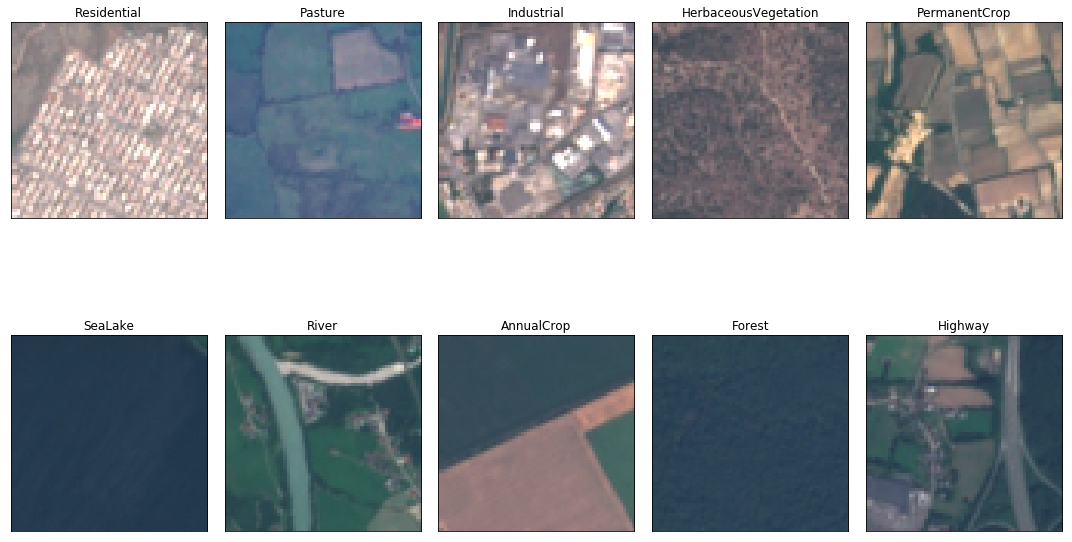

In [6]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2,ncols=5)
for i in range(len(categories)):
    row = i // 5
    col = i % 5
    # Get a random index from the category we care about
    ind = np.random.choice(np.where(labels==i)[0])
    ax[row, col].imshow(load_img(ind))
    ax[row, col].set_title(f"{categories[i]}")
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
fig.tight_layout()

# Model Building

Data transformations come first

In [29]:
import fastai
from fastai.vision import *
import torch

In [8]:
tfms = get_transforms(max_warp=0.0) # Applies fast.ai's default transforms
data = (ImageItemList.from_folder(datadir, recurse=True)
        .random_split_by_pct() # Train/Validation is 0.8/0.2 % of dataset
        .label_from_folder()
        .transform(tfms)
        .databunch() # Make into Fast.ai's dataset object
        .normalize([torch.tensor(0.0), torch.tensor(255.0)]) # Set range 0-1.0)
       )

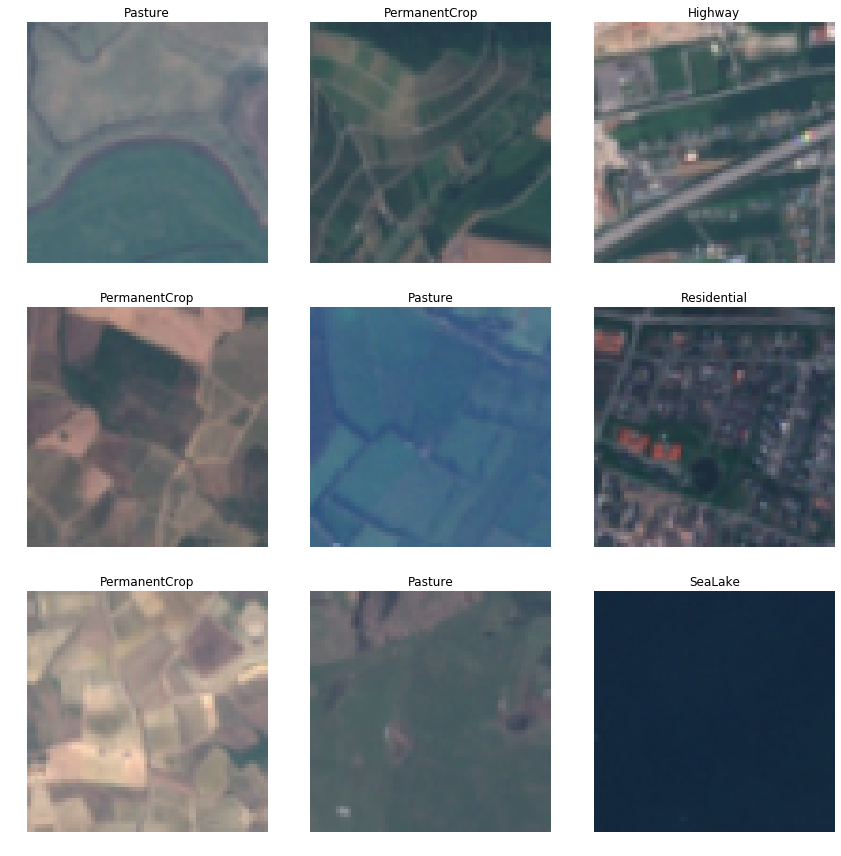

In [9]:
data.show_batch(rows=3)

In [47]:
mod = models.wrn_22()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


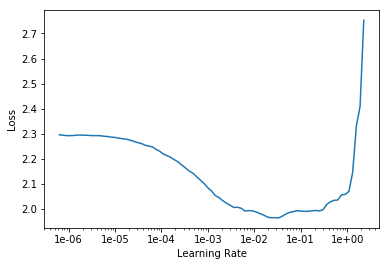

In [48]:
# learn = create_cnn(data, mod, metrics=accuracy)
learn = Learner(data, mod, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(2, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,1.093705,1.194531,0.545370
2,0.563484,0.585877,0.792222


In [50]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.674084,2.017356,0.496296
2,0.542524,0.875503,0.725000
3,0.400135,0.470429,0.842407
4,0.290713,0.309775,0.891481


In [51]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.423578,0.536024,0.820556
2,0.371620,0.287781,0.905926
3,0.247930,0.225678,0.926852
4,0.193399,0.167019,0.943704


In [60]:
learn.save("wrn22-94", return_path=True)

PosixPath('../EuroSat/models/wrn22-94.pth')

In [62]:
learn.fit_one_cycle(8, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.205905,0.255992,0.910926
2,0.292307,0.926892,0.757593
3,0.299708,0.387611,0.867778
4,0.230788,0.540017,0.821296
5,0.199721,0.220472,0.930185
6,0.154881,0.135988,0.954259
7,0.117200,0.115900,0.962963
8,0.103740,0.109035,0.964074


(64, 64)


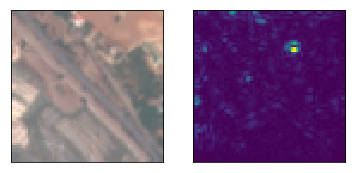

In [175]:
xs, ys = data.one_batch()
input_var = torch.autograd.Variable(xs[idx].unsqueeze(0).cuda(), requires_grad=True)
out = learn.model(input_var)
loss = learn.loss_func.func(out, ys[idx].unsqueeze(0).cuda())
loss.backward()
sal = np.transpose(input_var.grad.data.detach().cpu().numpy().squeeze(), (1, 2, 0))
abs_sal = np.abs(sal).max(axis=2)
print(abs_sal.shape)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.transpose(input_var[0].detach().cpu(), (1, 2, 0)))
ax[1].imshow(abs_sal)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [61]:
!ls -la ../EuroSat/models

total 201124
drwxrwxr-x  2 ngundotra ngundotra      4096 Jan 14 22:23 .
drwxr-xr-x 13 ngundotra ngundotra      4096 Jan 14 12:42 ..
-rw-rw-r--  1 ngundotra ngundotra  51268323 Jan 14 12:43 mini_train.pth
-rw-rw-r--  1 ngundotra ngundotra  38689220 Jan 14 21:56 tmp.pth
-rw-rw-r--  1 ngundotra ngundotra 115975870 Jan 14 22:24 wrn22-94.pth
